# Item-based CF算法与SVD 矩阵分解算法的对比

Calculating Metrics...
CF: P=0.0312, R=0.0569
SVD: P=0.0323, R=0.0590


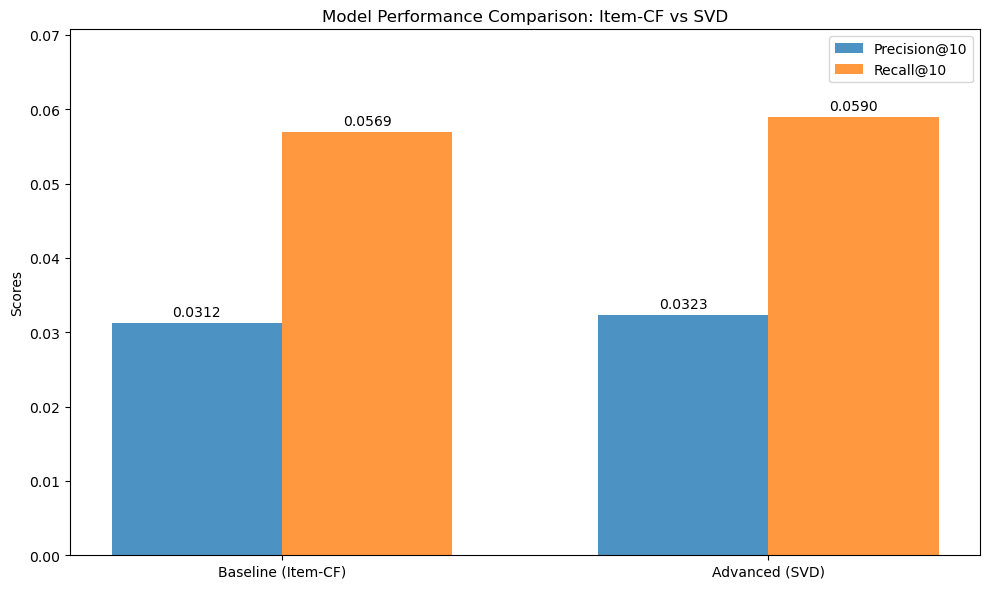

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# 1. Load Data
df_orders = pd.read_csv('cleaned_orders.csv')
df_logs = pd.read_csv('cleaned_behavior_logs.csv')

# 2. Build Interaction Matrix with Weights
weights = {'view': 1, 'click': 2, 'wishlist': 3, 'add_to_cart': 4, 'purchase': 5}
df_logs['score'] = df_logs['behavior_type'].map(weights).fillna(1)
log_interactions = df_logs.groupby(['customer_id', 'product_id'])['score'].sum().reset_index()

order_interactions = df_orders[['customer_id', 'product_id']].copy()
order_interactions['score'] = 5 

total_interactions = pd.concat([log_interactions, order_interactions])
# Take max score if duplicate (strongest intent)
final_interactions = total_interactions.groupby(['customer_id', 'product_id'])['score'].max().reset_index()

# 3. Train/Test Split (Item Hold-out)
# Filter users with >= 5 interactions for meaningful evaluation
user_counts = final_interactions['customer_id'].value_counts()
valid_users = user_counts[user_counts >= 5].index
filtered_interactions = final_interactions[final_interactions['customer_id'].isin(valid_users)]

# Stratified split: For each user, hold out 20% of items
train_df, test_df = train_test_split(filtered_interactions, test_size=0.2, stratify=filtered_interactions['customer_id'], random_state=42)

# 4. Evaluation Function (Precision@K, Recall@K)
# MODIFIED to return values instead of just print
def evaluate_model_metrics(recommendation_func, test_data, train_data, k=10):
    # Get ground truth: dict {user_id: set(product_ids)}
    ground_truth = test_data.groupby('customer_id')['product_id'].apply(set).to_dict()
    # Known items in train to exclude
    known_items = train_data.groupby('customer_id')['product_id'].apply(set).to_dict()
    
    precisions, recalls = [], []
    
    # Evaluate for sampled users to save time if needed, here all
    for uid, truth in ground_truth.items():
        if len(truth) == 0: continue
        
        # Get recommendations
        recs = recommendation_func(uid, k, known_items.get(uid, set()))
        if not recs:
            precisions.append(0)
            recalls.append(0)
            continue
            
        # Metrics
        hits = len(set(recs) & truth)
        precisions.append(hits / k)
        recalls.append(hits / len(truth))
        
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    return avg_precision, avg_recall

# 5. Model 1: Item-based CF (Baseline)
# Build Matrix from TRAIN
train_matrix = train_df.pivot(index='product_id', columns='customer_id', values='score').fillna(0)
item_sim = cosine_similarity(train_matrix)
item_sim_df = pd.DataFrame(item_sim, index=train_matrix.index, columns=train_matrix.index)

def recommend_item_cf(user_id, k, known_items_set):
    if user_id not in train_matrix.columns: return [] # Cold start user in test
    
    # User's history in train (Product IDs and Scores)
    user_history = train_matrix[user_id]
    user_history = user_history[user_history > 0]
    
    # Weighted Sum of similarities
    scores = {}
    for pid, rating in user_history.items():
        if pid not in item_sim_df.index: continue
        # Get similar items
        sims = item_sim_df[pid]
        # Optimization: filter known items later or iterate efficiently
        # Doing simple iteration here as in user code
        for sim_pid, sim_score in sims.items():
            if sim_pid in known_items_set: continue # Skip known
            scores[sim_pid] = scores.get(sim_pid, 0) + (sim_score * rating)
    
    # Sort
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [x[0] for x in sorted_scores[:k]]

# 6. Model 2: Matrix Factorization (SVD) - Advanced
user_item_matrix_train = train_df.pivot(index='customer_id', columns='product_id', values='score').fillna(0)
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors = svd.fit_transform(user_item_matrix_train)
item_factors = svd.components_

pred_matrix = np.dot(user_factors, item_factors)
pred_df = pd.DataFrame(pred_matrix, index=user_item_matrix_train.index, columns=user_item_matrix_train.columns)

def recommend_svd(user_id, k, known_items_set):
    if user_id not in pred_df.index: return []
    
    # Get all predicted scores for user
    user_scores = pred_df.loc[user_id]
    
    # Filter out known
    candidates = user_scores.index.difference(list(known_items_set))
    top_k = user_scores.loc[candidates].nlargest(k).index.tolist()
    return top_k

# 7. Run Evaluation and Capture Results
print("Calculating Metrics...")
cf_precision, cf_recall = evaluate_model_metrics(recommend_item_cf, test_df, train_df, k=10)
svd_precision, svd_recall = evaluate_model_metrics(recommend_svd, test_df, train_df, k=10)

print(f"CF: P={cf_precision:.4f}, R={cf_recall:.4f}")
print(f"SVD: P={svd_precision:.4f}, R={svd_recall:.4f}")

# 8. Visualization Code
models = ['Baseline (Item-CF)', 'Advanced (SVD)']
precision_scores = [cf_precision, svd_precision]
recall_scores = [cf_recall, svd_recall]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, precision_scores, width, label='Precision@10', color='#1f77b4', alpha=0.8)
rects2 = ax.bar(x + width/2, recall_scores, width, label='Recall@10', color='#ff7f0e', alpha=0.8)

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison: Item-CF vs SVD')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, max(max(precision_scores), max(recall_scores)) * 1.2) # Add some headroom

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('model_comparison_chart.png', dpi=300)
plt.show()